In [1]:
import json
%matplotlib inline


# create wordcloud with chinese

Wordcloud is a very good tool, but if you want to create
Chinese wordcloud only wordcloud is not enough. The file
shows how to use wordcloud with Chinese. First, you need a
Chinese word segmentation library jieba, jieba is now the
most elegant the most popular Chinese word segmentation tool in python.
You can use 'PIP install jieba'. To install it. As you can see,
at the same time using wordcloud with jieba very convenient


In [1]:
class TF_IDF_Model(object):
    def __init__(self, documents_list):
        self.documents_list = documents_list
        self.documents_number = len(documents_list)
        self.tf = []
        self.idf = {}
        self.init()

    def init(self):
        df = {}
        for document in self.documents_list:
            # compute term frequency
            temp = {}
            for word in document:
                temp[word] = temp.get(word, 0) + 1/len(document)
            self.tf.append(temp)
            for key in temp.keys():
                # compute document frequency with term
                df[key] = df.get(key, 0) + 1
        # compute inverse document frequency with term
        for key, value in df.items():
            self.idf[key] = np.log(self.documents_number / (value + 1))

    def get_score(self, query):
        dict = {}
        for q in query:
            score = 0.0
            for index in range(self.documents_number):
                if q not in self.tf[index]:
                    continue
                    # calculate score
                score += self.tf[index][q] * self.idf[q]
            if score < 0: score = 0
            dict[q] = score
        return dict


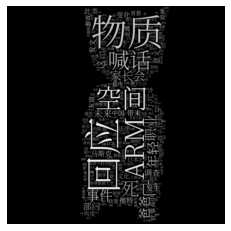

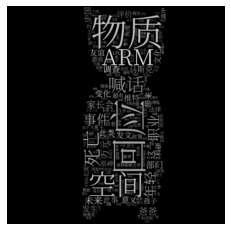

In [17]:
import jieba
import jieba.analyse
import multidict as multidict
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import json

"""
create chinese wordcloud using frequency
=============================
"""

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# 间隔词
stopwords_path = d + '/wc_cn/stopwords_cn_en.txt'

# Chinese fonts must be set
font_path = d + '/fonts/SourceHanSerif/SourceHanSerifK-Light.otf'
IDF_PATH = d + "/wc_cn/zhihuHot.txt"
TF_PATH = d + "/wc_cn/zhihuHot.txt"
# Read the whole text. 导入整个文档
# 微博某一天的热搜数据

# use jieba, 参数为整个文档， 输出中文词语列表
def jieba_processing_txt(text):
    # if you want use wordCloud,you need it add userdict by add_word()
    userdict_list = ['哈哈哈'] # 特殊不分割的词语
    for word in userdict_list:
        jieba.add_word(word)

    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)
    # [i for i in string if not i.isdigit()]
    # liststr = "/".join(seg_list) # 用 / 连接
    liststr = "/".join([i for i in seg_list if not i.isdigit()]) # 用 / 连接


    # 得出停用词列表, 将被忽略的停用词
    with open(stopwords_path, encoding='utf-8') as f_stop:
        f_stop_text = f_stop.read()
        f_stop_seg_list = f_stop_text.splitlines()
        # print(f_stop_seg_list)

    # 循环分割好的词语列表，去除空格 str.strip()，如果词语是停用词则除去,除去数字，得出最后的 mywordlist
    for myword in liststr.split('/'):
        if not (myword.strip() in f_stop_seg_list) and len(myword.strip()) > 1:
            mywordlist.append(myword)

    # 以,分隔开，拼接成一个字符串 word_list
    word_list = ','.join(mywordlist)
    # print(word_list)
    return word_list


def get_one_day_hot_data(IDF_PATH):
    return ''.join(get_all_hot_data(IDF_PATH)["2022-11-02"])

# 微博所有日期的dict
def get_all_hot_data(IDF_PATH):
    with open(IDF_PATH, 'r', encoding="utf-8") as tf:
        tf_json = tf.read()
    tf_dict = json.loads(tf_json)
    return tf_dict

# 微博所有日期热搜的分词list
def get_all_hot_words(all_hot_data):
    all_hot_words = []
    for key in all_hot_data.keys():
        # 把每一条热搜当成一个文档
        # hot_words 是某一天的热搜词
        for onehotSearch in all_hot_data[key]:
            # 某一条热搜词
            words = jieba_processing_txt(onehotSearch).split(",")
            # print(words)
            all_hot_words.append(words)
    # print(all_hot_words)
    return all_hot_words

# 统计频率，参数为词语列表，输出字典 MultiDict
def getFrequencyDictForText(word_list):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in word_list.split(","):
        val = tmpDict.get(text, 0)
        tmpDict[text] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])

    #  排序
    # fullTermsDict = sorted(fullTermsDict, key=lambda k, v: v[1], reverse = True)
    return fullTermsDict


def getFrequencyDictTF_IDF(onedayText, IDF_PATH):
    jieba.analyse.set_idf_path(IDF_PATH)
    keywords = jieba.analyse.extract_tags(sentence= onedayText, withWeight=True, topK=200)
    finalDict = {}
    for keyword in keywords:
        finalDict[keyword[0]] = keyword[1]
    # print(finalDict)
    return finalDict

# 使用自定义tfidf
def getFrequencyDictTFIDF_custom(all_hot_words, oneday_tf_list):
    oneday_list = []
    for word in oneday_tf_list.split(","):
        oneday_list.append(word)
    # print(all_hot_words)
    # print(oneday_list)
    model = TF_IDF_Model(all_hot_words)
    dict = model.get_score(oneday_list)
    return dict


# 生成图像的方法 参数是 字典 MultiDict 一键多值字典
def makeImage(Dict):
    mask = np.array(Image.open(d + "/wc_cn/cat.jpg"))
    # Chinese fonts must be set
    font_path = d + '/fonts/SourceHanSerif/SourceHanSerifK-Light.otf'

    wc = WordCloud(font_path=font_path , max_words=800, mask= mask)
    # generate word cloud
    wc.generate_from_frequencies(Dict)

    # 改变字体颜色
    default_colors = wc.to_array()
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
               interpolation="bilinear")

    wc.to_file('wordcloud.jpg')

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Using the recolor method and custom coloring functions.
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

#  "热搜1+热搜2+..."
one_day_hot_data = get_one_day_hot_data(IDF_PATH)

# "词语1,词语2,...“  某一天热搜的分词str
oneday_tf_list = jieba_processing_txt(one_day_hot_data)

# [["词语1,词语2,...“],["词语3,词语4,...“],...]  所有热搜的分词
all_hot_words = get_all_hot_words(get_all_hot_data(IDF_PATH))


# print((FrequencyDict))
FrequencyDict = getFrequencyDictForText(oneday_tf_list)
FrequencyDict_tfidf = getFrequencyDictTF_IDF(oneday_tf_list, IDF_PATH)
# 生成频率dict
FrequencyDict_tfidf_cus = getFrequencyDictTFIDF_custom(all_hot_words, oneday_tf_list)


# print(FrequencyDict_tfidf)
# print(FrequencyDict_tfidf_cus)
# 生成wordcloud
# 只使用tf
makeImage(FrequencyDict)
# 使用jieba的tiidf
makeImage(FrequencyDict_tfidf)
# 使用自定义tfidf
# makeImage(FrequencyDict_tfidf_cus)